In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter

plt.style.use('seaborn')
%matplotlib inline

In [2]:
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys
    
def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
    
    


In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

green_list_df = pd.read_csv('data/Green_misc_insertions_210525.csv')
date = '5/25/21'

In [4]:
green_list_df

,file_name,date,session,calibration,insertion,c_unique,i_in_c,i_unique,conditions
0,210330_spectrometer_tests/spect_test3.h5,3/30/21,session001,cal001,ins001,c001,i01,c001i01,white blank
1,210330_spectrometer_tests/spect_test3.h5,3/30/21,session001,cal001,ins002,c001,i02,c001i02,white blank moving
2,210330_spectrometer_tests/spect_test5.h5,3/30/21,session001,cal001,ins001,c002,i01,c002i01,baggie
3,210330_spectrometer_tests/spect_test5.h5,3/30/21,session001,cal001,ins002,c002,i02,c002i02,baggie moving
4,210330_spectrometer_tests/spect_test6.h5,3/30/21,session001,cal001,ins001,c003,i01,c003i01,green cap
...,...,...,...,...,...,...,...,...,...
115,210525_green_tests/testing_210525.h5,5/25/21,session002,cal001,ins002,c030,i02,c030i02,front yard test--later
116,210525_green_tests/testing_210525.h5,5/25/21,session002,cal002,ins003,c031,i01,c031i01,front yard test--later
117,210525_green_tests/testing_210525.h5,5/25/21,session002,cal002,ins004,c031,i02,c031i02,front yard test--later
118,210525_green_tests/testing_210525.h5,5/25/21,session002,cal003,ins005,c032,i01,c032i01,front yard test--later


In [5]:
today_df = green_list_df.loc[green_list_df['date'] == date]

In [6]:
today_df

,file_name,date,session,calibration,insertion,c_unique,i_in_c,i_unique,conditions
106,210525_green_tests/testing_210525.h5,5/25/21,session001,cal001,ins001,c026,i01,c026i01,front yard test
107,210525_green_tests/testing_210525.h5,5/25/21,session001,cal001,ins002,c026,i02,c026i02,front yard test
108,210525_green_tests/testing_210525.h5,5/25/21,session001,cal002,ins003,c027,i01,c027i01,front yard test
109,210525_green_tests/testing_210525.h5,5/25/21,session001,cal002,ins004,c027,i02,c027i02,front yard test
110,210525_green_tests/testing_210525.h5,5/25/21,session001,cal003,ins005,c028,i01,c028i01,front yard test
111,210525_green_tests/testing_210525.h5,5/25/21,session001,cal003,ins006,c028,i02,c028i02,front yard test
112,210525_green_tests/testing_210525.h5,5/25/21,session001,cal004,ins007,c029,i01,c029i01,front yard test
113,210525_green_tests/testing_210525.h5,5/25/21,session001,cal004,ins008,c029,i02,c029i02,front yard test
114,210525_green_tests/testing_210525.h5,5/25/21,session002,cal001,ins001,c030,i01,c030i01,front yard test--later
115,210525_green_tests/testing_210525.h5,5/25/21,session002,cal001,ins002,c030,i02,c030i02,front yard test--later


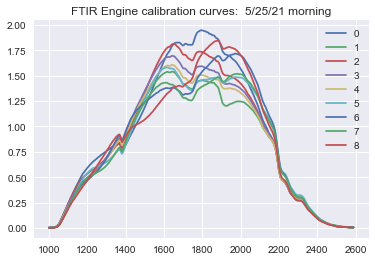

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210525_green_tests/testing_210525.h5'
file = path_name + file_name
calibrations = ['session001/cal001', 'session001/cal002', 'session001/cal003', 'session001/cal004', 'session001/cal005',
               'session002/cal001', 'session002/cal002', 'session002/cal003', 'session002/cal004']
cal_curves = []
waves = get_ftir_wavelength_vector(file, calibrations[0])
for calibration_path in calibrations:
    cal_curve = get_ftir_white_calibration_curve(file, calibration_path)
    cal_curves.append(cal_curve)

fig, ax = plt.subplots()
ax.set_title("FTIR Engine calibration curves:  5/25/21 morning")
for i in range(len(cal_curves)):    
    ax.plot(waves, cal_curves[i], label=i)
ax.legend()
plt.show()
plt.close()

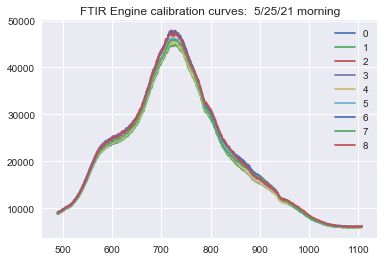

In [9]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210525_green_tests/testing_210525.h5'
file = path_name + file_name
calibrations = ['session001/cal001', 'session001/cal002', 'session001/cal003', 'session001/cal004', 'session001/cal005',
               'session002/cal001', 'session002/cal002', 'session002/cal003', 'session002/cal004']
cal_curves = []
waves = get_visible_wavelength_vector(file, calibrations[0])
for calibration_path in calibrations:
    cal_curve = get_visible_white_calibration_curve(file, calibration_path)
    cal_curves.append(cal_curve)

fig, ax = plt.subplots()
ax.set_title("FTIR Engine calibration curves:  5/25/21 morning")
for i in range(len(cal_curves)):    
    ax.plot(waves, cal_curves[i], label=i)
ax.legend()
plt.show()
plt.close()

In [10]:
yesterday_df = green_list_df.loc[green_list_df['date'] == '5/24/21']

In [11]:
df = pd.read_csv('data/All_green_files_210525.csv')

In [12]:
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]    
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


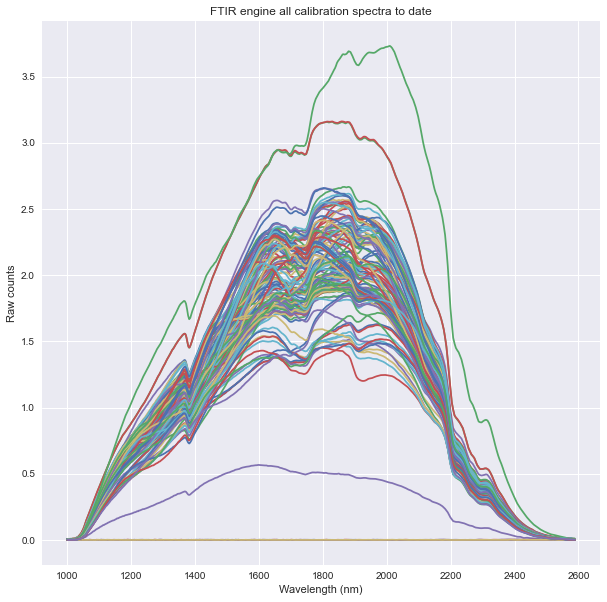

In [13]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum)
    except:
        print(file, cal_path)
plt.show()
plt.close()

210524_green_tests/blah_two_spects_210523.h5 session005/cal001


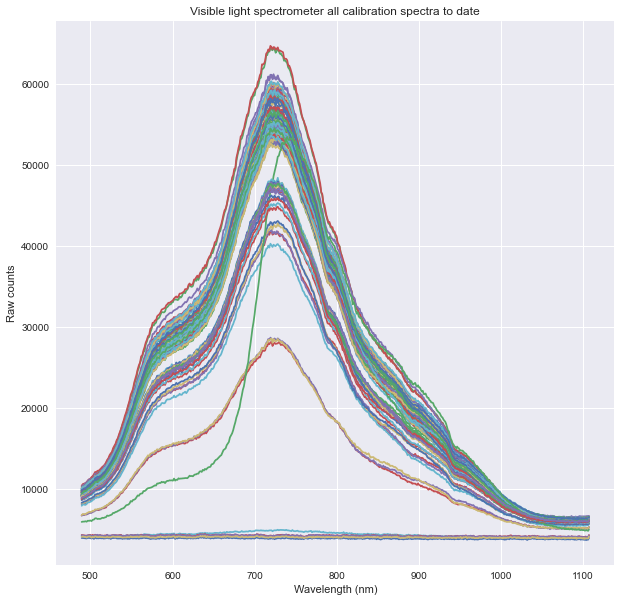

In [14]:
ath_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible light spectrometer all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        vis_waves = get_visible_wavelength_vector(file, cal_path)
        vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(vis_waves, vis_cal_spectrum)
    except:
        print(file_name, cal_path)
plt.show()
plt.close()

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


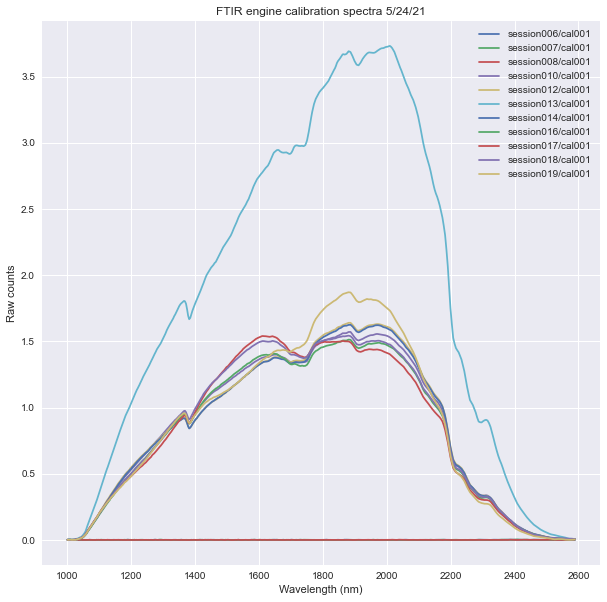

In [15]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/24/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine calibration spectra 5/24/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


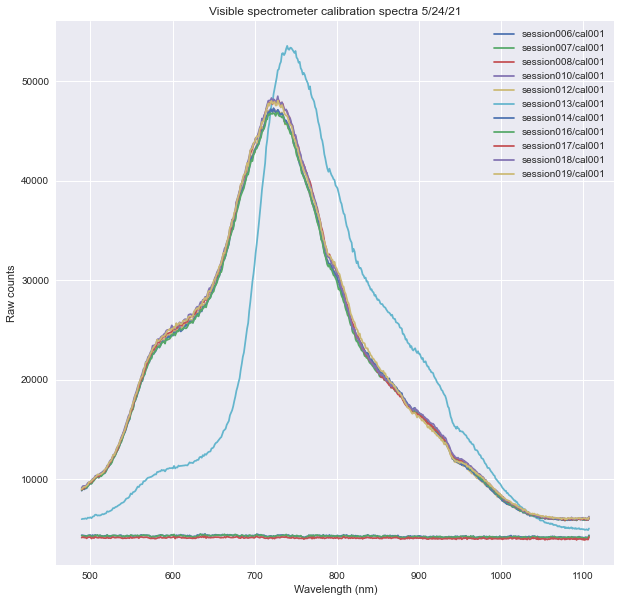

In [16]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/24/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible spectrometer calibration spectra 5/24/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

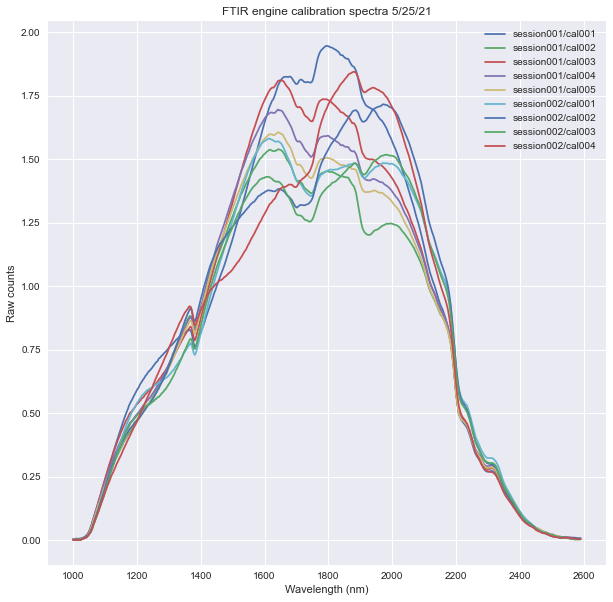

In [17]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/25/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine calibration spectra 5/25/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

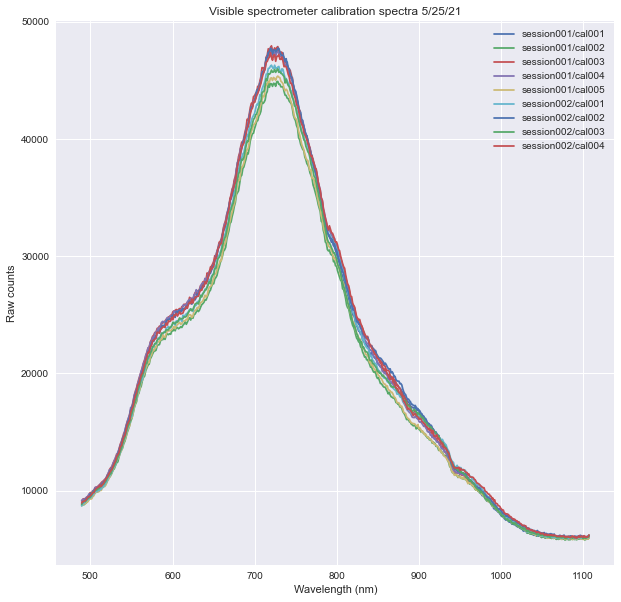

In [18]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/25/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible spectrometer calibration spectra 5/25/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

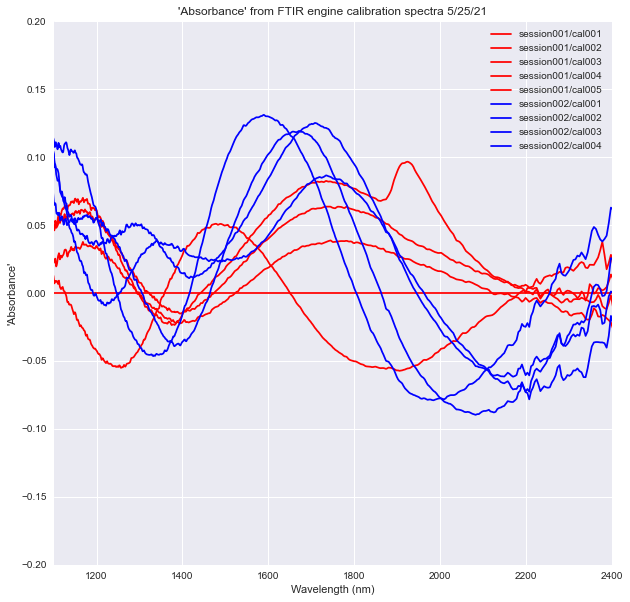

In [30]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/25/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session001/cal003'
reference_spectrum = get_ftir_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_ftir_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from FTIR engine calibration spectra 5/25/21")
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    if one_date_df['session'][index][0:11] == 'session001':
            color = 'r'
    else:
        color = 'b'
    try:
        
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

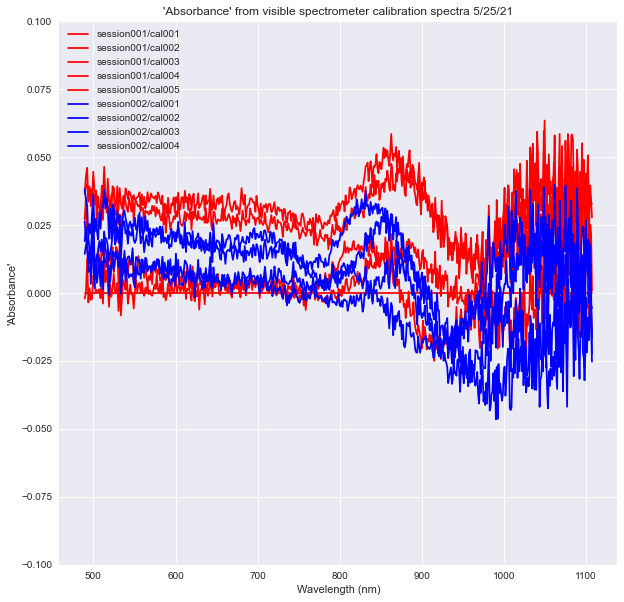

In [31]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/25/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session001/cal003'
reference_spectrum = get_visible_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_visible_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from visible spectrometer calibration spectra 5/25/21")
ax.set_ylim(-0.1, 0.1)
# ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    if one_date_df['session'][index][0:11] == 'session001':
            color = 'r'
    else:
        color = 'b'
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, color=color, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


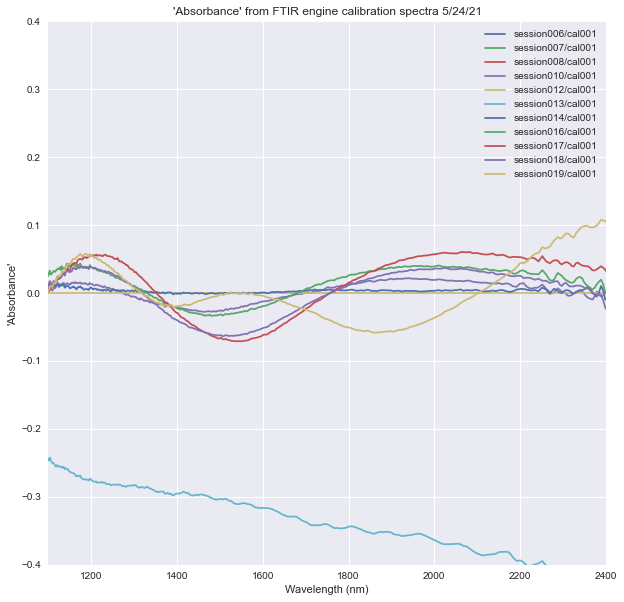

In [32]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/24/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session012/cal001'
reference_spectrum = get_ftir_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_ftir_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from FTIR engine calibration spectra 5/24/21")
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


<ipython-input-2-a283999372ad>:42: RuntimeWarning: invalid value encountered in log10
  absorbance = np.log10(inverse_reflectance.astype(np.float64))
<ipython-input-2-a283999372ad>:41: RuntimeWarning: divide by zero encountered in true_divide
  inverse_reflectance = 1/reflectance
<ipython-input-2-a283999372ad>:42: RuntimeWarning: invalid value encountered in log10
  absorbance = np.log10(inverse_reflectance.astype(np.float64))


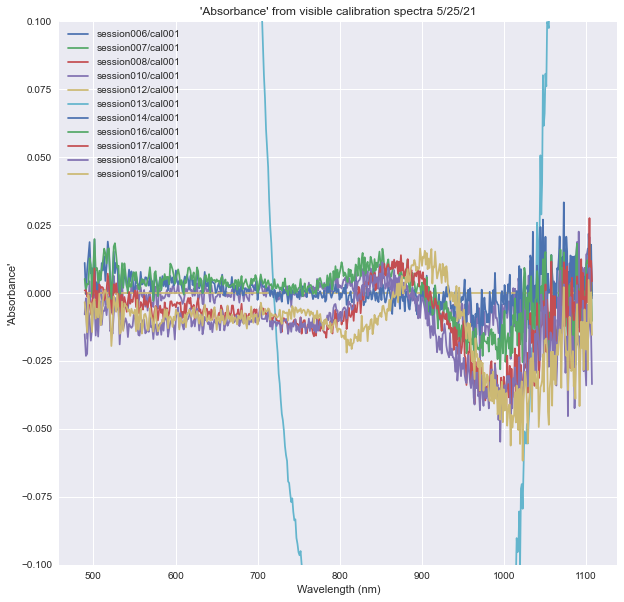

In [33]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/24/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session012/cal001'
reference_spectrum = get_visible_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_visible_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from visible calibration spectra 5/25/21")
ax.set_ylim(-0.1, 0.1)
# ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()